In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os,random
#os.environ["KERAS_BACKEND"] = "theano"
os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(2)   #disabled because we do not have a hardware GPU
import numpy as np
#import theano as th
#import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers import Input,merge
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model
from keras.regularizers import *
from keras.optimizers import adam
from keras.optimizers import adagrad
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras
from keras.utils import multi_gpu_model
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
import tensorflow as tf

import scipy.io as sio

In [ ]:
# fix random seed
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(2018)
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=4)


In [ ]:
seqLen = 128
nClass = 8
samNum = 100000 * nClass
# load train data
x_data_mat = sio.loadmat('/content/drive/My Drive/train_data_8class_awgn.mat')
x_data_complex = x_data_mat['train_data']
x_data_real = x_data_complex.real
x_data_imag = x_data_complex.imag
x_data_real = x_data_real.reshape((x_data_real.shape[0], seqLen, 1))
x_data_imag = x_data_imag.reshape((x_data_imag.shape[0], seqLen, 1))
x_train = np.stack((x_data_real, x_data_imag), axis=1)
y_data_mat = sio.loadmat('/content/drive/My Drive/train_label_8class_awgn.mat')
y_data = y_data_mat['train_label']
y_train = np_utils.to_categorical(y_data, nClass)

In [ ]:
x_train=np.reshape(x_train,(800000, 2, 128))
x_train.shape

(800000, 2, 128)

In [ ]:
y_train.shape

(800000, 8)

In [ ]:
index = np.arange(y_train.shape[0])
np.random.shuffle(index)
x_train = x_train[index,:]
y_train = y_train[index]

In [ ]:
type(x_train)

numpy.ndarray

In [ ]:
n_examples = x_train.shape[0]
n_train = (n_examples*9)//10 
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = x_train[train_idx]
X_test =  x_train[test_idx]
Y_train = y_train[train_idx]
Y_test =  y_train[test_idx]

In [ ]:
print('training started')
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
#classes = mods


training started
(720000, 2, 128) [2, 128]


In [ ]:
dr = 0.2 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0,2), data_format="channels_first"))
# error message occurs here!!!
model.add(Conv2D(kernel_initializer="glorot_uniform", name="conv1", activation="relu", data_format="channels_first", padding="valid", filters=256, kernel_size=(1, 3)))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0,2), data_format="channels_first"))
model.add(Conv2D(kernel_initializer="glorot_uniform", name="conv2", activation="relu", data_format="channels_first", padding="valid", filters=256, kernel_size=(2, 3)))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0,2), data_format="channels_first"))
model.add(Conv2D(kernel_initializer="glorot_uniform", name="conv3", activation="relu", data_format="channels_first", padding="valid", filters=80, kernel_size=(1, 3)))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0,2), data_format="channels_first"))
model.add(Conv2D(kernel_initializer="glorot_uniform", name="conv4", activation="relu", data_format="channels_first", padding="valid", filters=80, kernel_size=(1, 3)))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2), data_format="channels_first"))

model.add(Flatten())
# 128 (1) -> 11200; 64 (1/2) -> 6080; 32 (1/4) -> 3520; 16 (1/8) -> 2240; 8 (1/16) -> 1600; 4 (1/32) -> 1280
model.add(Dense(256, activation='relu', init='he_normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( 8, init='he_normal', name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([8]))
#opt=adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()
#The shape of the input to "Flatten" is not fully defined (got (0, 6, 80). 
#Make sure to pass a complete "input_shape" or "batch_input_shape" argument to the first layer in your model.





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 2, 132)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 2, 130)       1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 2, 130)       0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 256, 2, 134)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 256, 1, 132)       393472    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", name="dense1", kernel_initializer="he_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, name="dense2", kernel_initializer="he_normal")`


In [ ]:
# In[6]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

# In[7]:
# Train the Model
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = '/content/drive/My Drive/mydatacnn256.wts.h5'
#model = multi_gpu_model(models)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    validation_split=0.1,
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss',  save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,  mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

Train on 648000 samples, validate on 72000 samples
Epoch 1/100
648000/648000 [==============================] - 289s 446us/step - loss: 0.7676 - acc: 0.6455 - val_loss: 0.7435 - val_acc: 0.6530
Epoch 2/100
648000/648000 [==============================] - 288s 445us/step - loss: 0.7523 - acc: 0.6508 - val_loss: 0.7387 - val_acc: 0.6555
Epoch 3/100
648000/648000 [==============================] - 290s 447us/step - loss: 0.7441 - acc: 0.6558 - val_loss: 0.7374 - val_acc: 0.6590
Epoch 4/100
648000/648000 [==============================] - 290s 447us/step - loss: 0.7388 - acc: 0.6581 - val_loss: 0.7520 - val_acc: 0.6504
Epoch 5/100
648000/648000 [==============================] - 289s 447us/step - loss: 0.7349 - acc: 0.6609 - val_loss: 0.7227 - val_acc: 0.6660
Epoch 6/100
648000/648000 [==============================] - 289s 445us/step - loss: 0.7289 - acc: 0.6649 - val_loss: 0.7284 - val_acc: 0.6622
Epoch 7/100
648000/648000 [==============================] - 288s 444us/step - loss: 0.7243

In [ ]:
# Evaluate and Plot Model Performance
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=0)
print(score)

[0.7217996305465698, 0.664675]


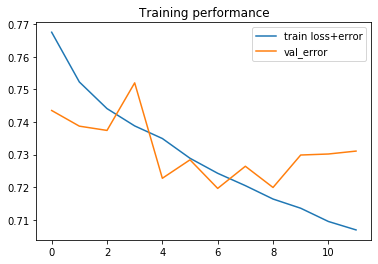

In [ ]:
# Show loss curves 
%matplotlib inline
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()
plt.savefig('/content/drive/My Drive/Train_perf_cnnmydata.png', dpi=100)	#save image

In [ ]:
classes=['BPSK','PAM4','PAM8','PSK4','PSK8','QAM4','QAM16','QAM64']

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

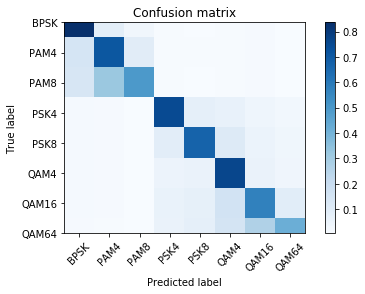

In [ ]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)
plt.savefig('/content/drive/My Drive/confusion_cnn_mydata.png',dpi=100)